In [28]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
import os
import statsmodels.api as sm
import sys

sys.path.append("/home/gy/nandu/nandu-research/GongYun/Util")
from gxUtil import *
from gxConfig import *

In [50]:
instrument = "jd"
tradeInstrument = instrument.upper()+"0001"
priceTick = d_priceTick[instrument]
multiplier = d_multiplier[instrument]
sim_result_dir = "/mnt/users/gy/simulation_result/"+tradeInstrument+"/"
feeReturnRate= 0.33

FEE = 0*(1-feeReturnRate)  # per lot
fee = FEE/multiplier # per unit
openRate = 0.00015*(1-feeReturnRate)
closeRate = 0.00015*(1-feeReturnRate)

l_strategy = [ "kronos_base_multiAssist",
              # "kronos_base_spread",
              #"kronos_base_spread_favSize",
              #"kronos_base_multiAssist_noReturn",

             ] 

startDate = "20210101"
endDate="20210118"

In [51]:
d_strategyDate = {}
for strategy in l_strategy:
    l_thisStrategyDate=[]
    for dirpath,dirnames,filenames in os.walk(sim_result_dir+strategy):
        for dirname in dirnames:
            l_thisStrategyDate.append(dirname)
    d_strategyDate[strategy] = l_thisStrategyDate
l_date = ["initial"]
for key in d_strategyDate.keys():
    if l_date == ["initial"]:
        l_date = d_strategyDate[key]
    else:
        l_date = [date for date in l_date if date in d_strategyDate[key]]
l_date.sort()   

l_date_2 = []
for date in l_date:
    if (date>=startDate) & (date<=endDate):
        l_date_2.append(date)
l_date = l_date_2
l_date.sort()

In [52]:
### real trading log
df_log_table = pd.DataFrame()
for date in l_date:
    if not os.path.exists("/mnt/users/gy/simulation_data/"+tradeInstrument+"/log_data/trade_log_"+date+".csv"):
        print("No trading results on "+date)
        df_tableThisDay = pd.DataFrame()
        df_tableThisDay.loc[0,"PNL"] = 0
        df_tableThisDay.loc[0,"TRADING_VOLUME"] = 0
        df_tableThisDay.loc[0,"PER_TRADE"] = 0.0
        df_tableThisDay.loc[0,"MKT_DATE"] = date
        df_log_table = df_log_table.append(df_tableThisDay)
        continue
    df_trade = pd.read_csv("/mnt/users/gy/simulation_data/"+tradeInstrument+"/log_data/trade_log_"+date+".csv")
    df_trade["DIRECTION"] = df_trade["DIRECTION"].apply(lambda x: 1 if x == "BUY" else -1)
    
    df_trade["NET_VOLUME"] = df_trade["VOLUME"] * df_trade["DIRECTION"]
    netVolume = df_trade["NET_VOLUME"].sum()
    
    df_trade["INCOME"] = (df_trade["PRICE"]*(1+(openRate+closeRate)/2*df_trade["DIRECTION"])+fee*df_trade["DIRECTION"])*df_trade["DIRECTION"]*(-1)*df_trade["VOLUME"]
    pnlThisDay = (df_trade["INCOME"].sum() + df_trade.iloc[-1].PRICE*netVolume - (df_trade.iloc[-1].PRICE*(openRate+closeRate)/2+fee)*abs(netVolume))*multiplier
    volumeThisDay = df_trade["VOLUME"].sum()
    df_tableThisDay = pd.DataFrame()
    df_tableThisDay.loc[0,"PNL"] = pnlThisDay
    df_tableThisDay.loc[0,"TRADING_VOLUME"] = volumeThisDay
    df_tableThisDay.loc[0,"PER_TRADE"] = float(pnlThisDay/volumeThisDay)
    df_tableThisDay.loc[0,"MKT_DATE"] = date
    df_log_table = df_log_table.append(df_tableThisDay)
    
df_log_table["cumsumPNL"]=df_log_table["PNL"].cumsum()
df_log_table["cumsumTradeVolume"]=df_log_table["TRADING_VOLUME"].cumsum()

In [53]:
dict_results = {}
for strategy in l_strategy:
    df_table = pd.DataFrame()
    df_parameter = pd.DataFrame()
    for date in l_date:
        df_table_day = pd.read_csv(sim_result_dir+strategy+"/"+date+"/"+instrument+"_table_"+date+".csv")
        df_table_day["origIndex"] = df_table_day.index
        df_table_day["mktDate"] = date
        df_table = df_table.append(df_table_day)
    
        df_parameter_day = pd.read_csv(sim_result_dir+strategy+"/"+date+"/"+instrument+"_parameter_"+date+".csv").T
        df_parameter_day.columns = df_parameter_day.loc["Unnamed: 0"]
        df_parameter_day.drop(["Unnamed: 0"],inplace = True)
        df_parameter_day["origIndex"] = df_parameter_day.index
        df_parameter_day["mktDate"] = date
        df_parameter = df_parameter.append(df_parameter_day)
    df_table["OLD_INDEX"] = df_table.index
    df_table_useOrderLog = df_table.loc[df_table["OLD_INDEX"]==0].copy()
    df_table_useOrderLog["AllSuccess"] = pd.to_numeric(df_table_useOrderLog["AllSuccess"])
    df_table_useOrderLog["CancelF"] = pd.to_numeric(df_table_useOrderLog["CancelF"])
    df_table_useOrderLog["JoinF"] = pd.to_numeric(df_table_useOrderLog["JoinF"])
    df_table_useOrderLog["TakeF"] = pd.to_numeric(df_table_useOrderLog["TakeF"])
    df_table_useOrderLog["ImproveF"] = pd.to_numeric(df_table_useOrderLog["ImproveF"])
    
    df_table_notUseOrderLog = df_table.loc[df_table["OLD_INDEX"]==1].copy() 
    df_table_notUseOrderLog["AllSuccess"] = pd.to_numeric(df_table_notUseOrderLog["AllSuccess"])


    
    df_parameter["OLD_INDEX"] = df_parameter.index

    df_parameter_useOrderLog = df_parameter.loc[df_parameter["OLD_INDEX"]=="0"].copy() 
    # terminals in different senarios
    df_parameter_useOrderLog["terminal"] = pd.to_numeric(df_parameter_useOrderLog["terminal"])
    df_parameter_useOrderLog["cumsumPNL"]=df_parameter_useOrderLog["terminal"].cumsum()    
    df_parameter_useOrderLog["allSuccessTerminal"] = pd.to_numeric(df_parameter_useOrderLog["allSuccessTerminal"])
    df_parameter_useOrderLog["cumsumAllSuccessPNL"]=df_parameter_useOrderLog["allSuccessTerminal"].cumsum() 
    df_parameter_useOrderLog["cancelFailedTerminal"] = pd.to_numeric(df_parameter_useOrderLog["cancelFailedTerminal"])
    df_parameter_useOrderLog["cumsumCancelFailedPNL"]=df_parameter_useOrderLog["cancelFailedTerminal"].cumsum()     
    df_parameter_useOrderLog["joinFailedTerminal"] = pd.to_numeric(df_parameter_useOrderLog["joinFailedTerminal"])
    df_parameter_useOrderLog["cumsumJoinFailedPNL"]=df_parameter_useOrderLog["joinFailedTerminal"].cumsum()     
    df_parameter_useOrderLog["takingFailedTerminal"] = pd.to_numeric(df_parameter_useOrderLog["takingFailedTerminal"])
    df_parameter_useOrderLog["cumsumTakeFailedPNL"]=df_parameter_useOrderLog["takingFailedTerminal"].cumsum()      
    df_parameter_useOrderLog["improvingFailedTerminal"] = pd.to_numeric(df_parameter_useOrderLog["improvingFailedTerminal"])
    df_parameter_useOrderLog["cumsumImproveFailedPNL"]=df_parameter_useOrderLog["improvingFailedTerminal"].cumsum()   
    df_parameter_useOrderLog["allFailedTerminal"] = pd.to_numeric(df_parameter_useOrderLog["allFailedTerminal"])
    df_parameter_useOrderLog["cumsumAllFailedPNL"]=df_parameter_useOrderLog["allFailedTerminal"].cumsum()   
    # cancel number
    df_parameter_useOrderLog["allSuccessCancelNum"] = pd.to_numeric(df_parameter_useOrderLog["allSuccessCancelNum"])

    # tradeVolume in different senarios
    df_parameter_useOrderLog["allSuccessTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["allSuccessTradeNum"])
    df_parameter_useOrderLog["cancelFailedTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["cancelFailedTradeNum"])
    df_parameter_useOrderLog["takingFailedTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["takingFailedTradeNum"])
    df_parameter_useOrderLog["improvingFailedTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["improvingFailedTradeNum"])
    df_parameter_useOrderLog["joinFailedTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["joinFailedTradeNum"])
    df_parameter_useOrderLog["allFailedTradeNum"] = pd.to_numeric(df_parameter_useOrderLog["allFailedTradeNum"]) 
    
    df_parameter_useOrderLog["allSuccessCancelNum"] = pd.to_numeric(df_parameter_useOrderLog["allSuccessCancelNum"])
    
    df_parameter_useOrderLog["cumsumAllSuccessTradeVolume"]=df_parameter_useOrderLog["allSuccessTradeNum"].cumsum()
    df_parameter_useOrderLog["cumsumCancelFailedTradeVolume"]=df_parameter_useOrderLog["cancelFailedTradeNum"].cumsum()
    df_parameter_useOrderLog["cumsumTakeFailedTradeVolume"]=df_parameter_useOrderLog["takingFailedTradeNum"].cumsum()
    df_parameter_useOrderLog["cumsumImproveFailedTradeVolume"]=df_parameter_useOrderLog["improvingFailedTradeNum"].cumsum()
    df_parameter_useOrderLog["cumsumJoinFailedTradeVolume"]=df_parameter_useOrderLog["joinFailedTradeNum"].cumsum()
    df_parameter_useOrderLog["cumsumAllFailedTradeVolume"]=df_parameter_useOrderLog["allFailedTradeNum"].cumsum()
    
    df_parameter_useOrderLog["cumsumAllSuccessCancelVolume"]=df_parameter_useOrderLog["allSuccessCancelNum"].cumsum()
    
    ### Not use OrderLog
    df_parameter_notUseOrderLog = df_parameter.loc[df_parameter["OLD_INDEX"]=="1"].copy() 
    df_parameter_notUseOrderLog["allSuccessCancelNum"] = pd.to_numeric(df_parameter_notUseOrderLog["allSuccessCancelNum"])
    df_parameter_notUseOrderLog["terminal"] = pd.to_numeric(df_parameter_notUseOrderLog["terminal"])
    df_parameter_notUseOrderLog["cumsumPNL"]=df_parameter_notUseOrderLog["terminal"].cumsum()
    df_parameter_notUseOrderLog["allSuccessTradeNum"] = pd.to_numeric(df_parameter_notUseOrderLog["allSuccessTradeNum"])
    df_parameter_notUseOrderLog["cumsumTradeVolume"]=df_parameter_notUseOrderLog["allSuccessTradeNum"].cumsum()
    dict_results[strategy] = [df_table_useOrderLog,df_parameter_useOrderLog,df_table_notUseOrderLog,df_parameter_notUseOrderLog]

In [54]:
df_answer = pd.DataFrame()
for strategy in l_strategy:
    df = dict_results[strategy][1]
    l_data = []
    l_data.append(strategy)
    l_data.append(df.terminal.sum()*multiplier)
    l_data.append(df.allSuccessTerminal.sum()/df.allSuccessTradeNum.sum()*multiplier)
    l_data.append(df.cancelFailedTerminal.sum()/df.cancelFailedTradeNum.sum()*multiplier)
    l_data.append(df.joinFailedTerminal.sum()/df.joinFailedTradeNum.sum()*multiplier)
    l_data.append(df.improvingFailedTerminal.sum()/df.improvingFailedTradeNum.sum()*multiplier)
    l_data.append(df.takingFailedTerminal.sum()/df.takingFailedTradeNum.sum()*multiplier)
    l_data.append(df.allFailedTerminal.sum()/df.allFailedTradeNum.sum()*multiplier)
    l_data.append(df.allSuccessTradeNum.sum())
    df_answer_tmp = pd.DataFrame(l_data)
    df_answer = df_answer.append(df_answer_tmp.T)
df_answer.columns=["Strategy","TotalTerminal","AllS","CancelF","JoinF","ImproveF","TakeF","AllF","AllS-TradingVolume"]

In [55]:
df_answer

,Strategy,TotalTerminal,AllS,CancelF,JoinF,ImproveF,TakeF,AllF,AllS-TradingVolume
0,kronos_base_multiAssist,324801,2.66375,2.54591,2.48889,2.41958,2.44952,2.0463,135960


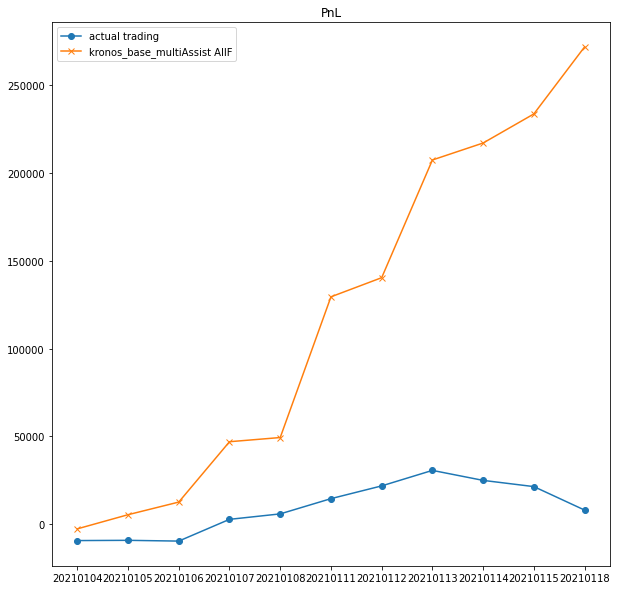

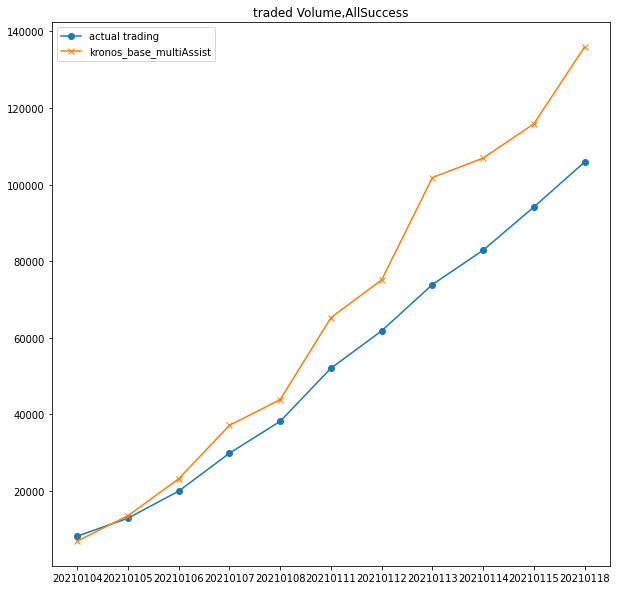

In [56]:
# PnL 
plt.figure(figsize=(10,10))
plt.title("PnL")
plt.plot(df_log_table.MKT_DATE,df_log_table.cumsumPNL,label="actual trading",marker='o')

#for strategy in l_strategy:
for strategy in l_strategy:
    if strategy == "kronos_base":
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessPNL*multiplier,linestyle="--",marker="o",label=strategy+" AllS") 
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumCancelFailedPNL*multiplier,linestyle="--",label=strategy+" CancelF")    
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumJoinFailedPNL*multiplier,linestyle="--",label=strategy+" JoinF")    
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumImproveFailedPNL*multiplier,linestyle="--",label=strategy+" ImpF")    
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumTakeFailedPNL*multiplier,linestyle="--",label=strategy+" TakeF")    

        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumPNL*multiplier,linestyle="--",marker="o",label=strategy+" Avg")    
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllFailedPNL*multiplier,linestyle="--",marker="o",label=strategy+" AllF")    

    else:
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessPNL*multiplier,marker="x",label=strategy+" AllS") 
        #plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumPNL*multiplier,marker="x",label=strategy+" Avg")
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllFailedPNL*multiplier,marker="x",label=strategy+" AllF")    

plt.legend(loc="upper left")
plt.show()
# Trading Volume AllSuccess
plt.figure(figsize=(10,10))
plt.title("traded Volume,AllSuccess")
plt.plot(df_log_table.MKT_DATE,df_log_table.cumsumTradeVolume,marker='o',label="actual trading")
for strategy in l_strategy:
#for strategy in ["kronos_base","kronos_assist_2"]:

    if strategy == "kronos_base":
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessTradeVolume,linestyle="--",marker='o',label=strategy)
    else:
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessTradeVolume,marker='x',label=strategy)

plt.legend(loc="upper left")
plt.show()

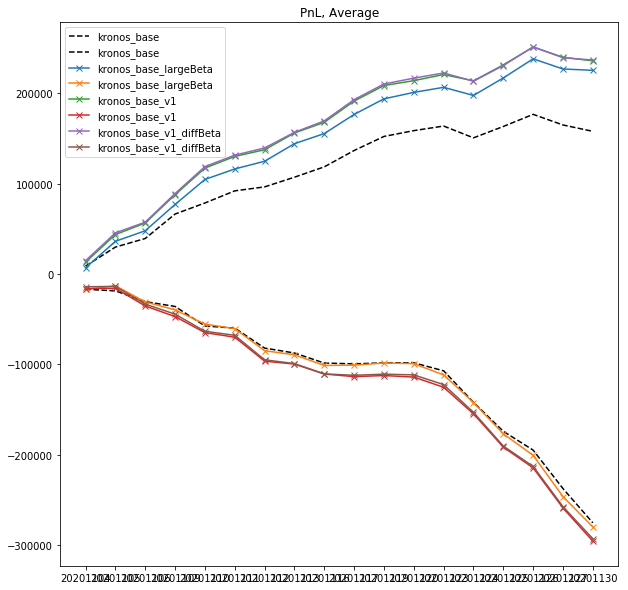

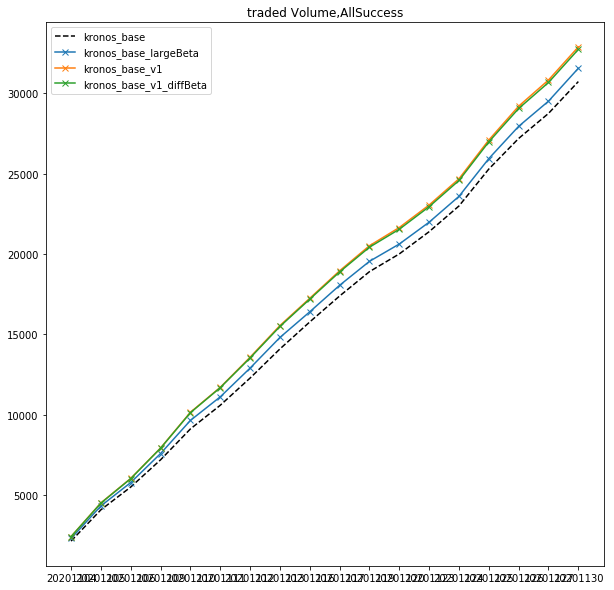

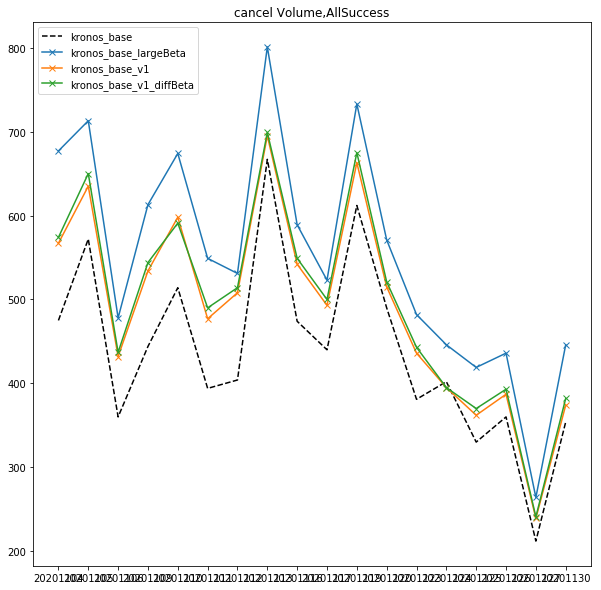

In [9]:
plt.figure(figsize=(10,10))
plt.title("PnL, Average")
# real trading data
#plt.plot(df_log_table.mktDate,df_log_table.cumsumPNL_fee,marker='o',label="actual trading")
for strategy in l_strategy:
    if strategy == "kronos_base":
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumPNL*multiplier,linestyle="--",color="black",label=strategy)
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllFailedPNL*multiplier,linestyle="--",color="black",label=strategy)
    
    else:
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumPNL*multiplier,marker='x',label=strategy)
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllFailedPNL*multiplier,marker='x',label=strategy)

plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10,10))
plt.title("traded Volume,AllSuccess")
#plt.plot(df_log_table.mktDate,df_log_table.cumsumTradeVolume,marker='o',label="actual trading")
for strategy in l_strategy:
    if strategy == "kronos_base":
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessTradeVolume,linestyle="--",color="black",label=strategy)
    else:
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].cumsumAllSuccessTradeVolume,marker='x',label=strategy)

plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10,10))
plt.title("cancel Volume,AllSuccess")
#plt.plot(df_log_table.mktDate,df_log_table.cancelled_volume,marker='o',label="actual trading")
for strategy in l_strategy:
    if strategy == "kronos_base":
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].allSuccessCancelNum,linestyle="--",color="black",label=strategy)
    else:
        plt.plot(dict_results[strategy][1].mktDate,dict_results[strategy][1].allSuccessCancelNum,marker='x',label=strategy)

plt.legend(loc="upper left")
plt.show()